In [23]:
!pip install kaggle

In [24]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
#!/bin/bash
!kaggle datasets download jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 90% 297M/331M [00:00<00:00, 393MB/s]
100% 331M/331M [00:00<00:00, 401MB/s]


In [4]:
# extracting the compressedc dataset
from zipfile import ZipFile
dataset = '/content/utkface-new.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("Extracted")


Extracted


In [5]:
# importing the libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import os
from PIL import Image


In [6]:

def label_gender_processing(filename) :
  gender = filename.split('_')[1]
  if gender == '0':
    return 0
  else :
    return 1


In [7]:
base_dir = '/content/UTKFace'
image_list = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if f.lower().endswith('.jpg')]
gender = [] # 0-male 1-female
valid = []
for img in image_list:
  if not os.path.exists(img):
        print(f"File not found: {img}")
        continue
  g = label_gender_processing(img)
  if g is not None:
    gender.append(g)
    valid.append(img)

In [8]:
gender[:5]

[1, 0, 1, 0, 0]

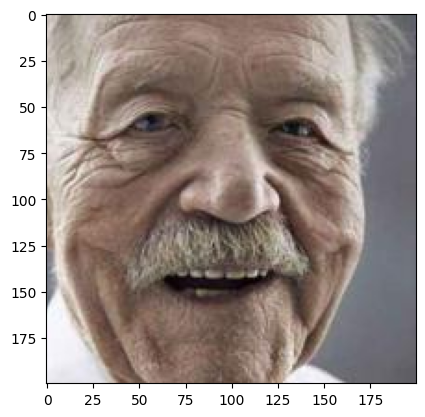

In [9]:
from google.colab.patches import cv2_imshow
img = Image.open('/content/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg')
plt.imshow(img)

(200, 200)


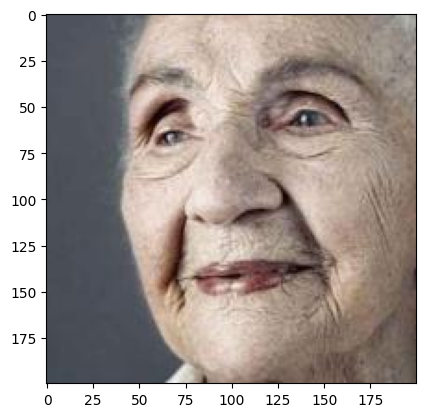

In [10]:
from google.colab.patches import cv2_imshow
img = Image.open('/content/UTKFace/100_1_0_20170112213001988.jpg.chip.jpg')
plt.imshow(img)
print(img.size)

(200, 200)


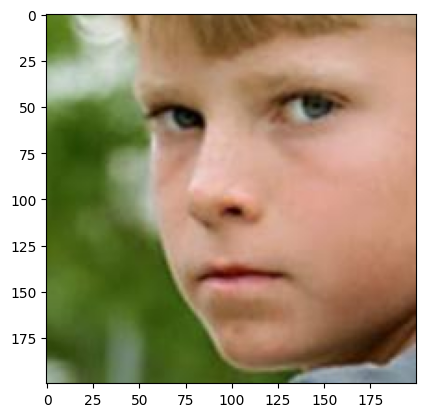

In [11]:
from google.colab.patches import cv2_imshow
img = Image.open('/content/UTKFace/11_0_0_20170110220518578.jpg.chip.jpg')
plt.imshow(img)
print(img.size)

In [12]:
import tensorflow as tf
from tensorflow import keras

In [13]:
# create tensorflow dataset
def parse_image(file_path, label):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img,channels = 3)
  img = tf.image.resize(img,[200,200])
  img = img/255.0
  return img,label

In [14]:
# Build dataset with batching
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((valid, gender))
dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.filter(lambda img, label: img is not None)  # Filter invalid images
# dataset = dataset.cache()  # Cache for performance
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size)  # Batch splitting
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [15]:
# Split dataset into train and test
dataset_size = len(valid)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

X_train = dataset.take(train_size // batch_size)
X_test = dataset.skip(train_size // batch_size)

In [16]:
# Define Keras model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(2, activation='sigmoid')  # Binary classification for gender
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
history = model.fit(X_train, epochs=10, validation_data=X_test)

Epoch 1/10
    592/Unknown 31s 37ms/step - accuracy: 0.6738 - loss: 0.6080

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


592/592 ━━━━━━━━━━━━━━━━━━━━ 44s 59ms/step - accuracy: 0.6740 - loss: 0.6078 - val_accuracy: 0.8474 - val_loss: 0.3376
Epoch 2/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 74s 56ms/step - accuracy: 0.8454 - loss: 0.3451 - val_accuracy: 0.8602 - val_loss: 0.3102
Epoch 3/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.8713 - loss: 0.2971 - val_accuracy: 0.8654 - val_loss: 0.3013
Epoch 4/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 34s 57ms/step - accuracy: 0.8841 - loss: 0.2704 - val_accuracy: 0.8841 - val_loss: 0.2664
Epoch 5/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.8888 - loss: 0.2497 - val_accuracy: 0.8776 - val_loss: 0.2919
Epoch 6/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - accuracy: 0.9029 - loss: 0.2249 - val_accuracy: 0.8757 - val_loss: 0.2775
Epoch 7/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 34s 57ms/step - accuracy: 0.9083 - loss: 0.2124 - val_accuracy: 0.8736 - val_loss: 0.2983
Epoch 8/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.9157 - loss: 0.1989 - val_accurac

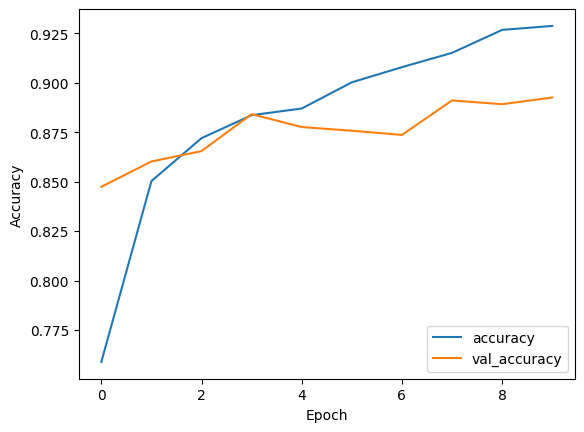

In [19]:
# plot
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

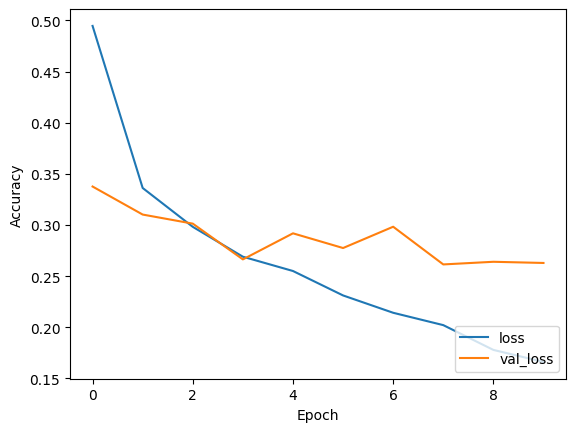

In [20]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [21]:
from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/MyDrive/gender_model.h5')


Mounted at /content/drive


Enter the path of the image/content/male.jpg


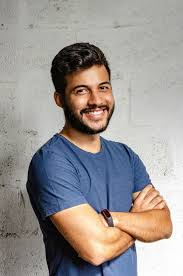

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
The person is a male


In [22]:
# prediction system

input_image_path = input("Enter the path of the image")
input_image = cv2.imread(input_image_path)
cv2_imshow(input_image)
input_image = cv2.resize(input_image, (200, 200))
input_image = input_image / 255.0
input_image = np.reshape(input_image, (1, 200, 200, 3))
prediction = model.predict(input_image)

label = np.argmax(prediction)
if label == 1:
  print("The person is a female")
else:
  print("The person is a male")